In [1]:
import json
import pathlib
import warnings
from concurrent.futures import ProcessPoolExecutor, as_completed

import anndata
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from scipy.sparse import csr_matrix, load_npz, save_npz, vstack
from scipy.stats import rankdata
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
"""
See here https://stackoverflow.com/questions/52371329/fast-spearman-correlation-between-two-pandas-dataframes

Calculate correlation between two matrix, row by row
"""

from numba import njit
import numpy as np


@njit
def _mean(a):
    n = len(a)
    b = np.empty(n)
    for i in range(n):
        b[i] = a[i].mean()
    return b


@njit
def _std(a):
    n = len(a)
    b = np.empty(n)
    for i in range(n):
        b[i] = a[i].std()
    return b


@njit
def _corr(a, b):
    """
    Correlation between rows in a and b, no nan value
    """
    n, k = a.shape
    m, k = b.shape

    mu_a = _mean(a)
    mu_b = _mean(b)
    sig_a = _std(a)
    sig_b = _std(b)

    out = np.empty((n, m))

    for i in range(n):
        for j in range(m):
            _sig_a = sig_a[i]
            _sig_b = sig_b[j]
            if _sig_a == 0 or _sig_b == 0:
                # if any variable std == 0
                out[i, j] = np.nan
            else:
                out[i, j] = (a[i] - mu_a[i]) @ (b[j] -
                                                mu_b[j]) / k / _sig_a / _sig_b
    return out


def corr(a, b, method='pearson'):
    if method.lower()[0] == 'p':
        pass
    elif method.lower()[0] == 's':
        # turn a, b in to rank matrix
        a = a.argsort(axis=1).argsort(axis=1)
        b = b.argsort(axis=1).argsort(axis=1)
    else:
        raise ValueError('Method can only be pearson or spearman')

    return _corr(a, b)


def chunk_corr(dmr_data, gene_data, mask, cutoff):
    record = corr(a=dmr_data, b=gene_data)
    record[np.abs(record) < cutoff] = 0
    pass_record = csr_matrix(record)
    masked_pass_record = pass_record.multiply(mask)
    return masked_pass_record

## Parameters

In [3]:
n_pcs = 20
k = 15
resolution = 1
use_clusters = ["CA1 Ak5", "CA1 Chrm3", "CA1 Kif26a", "CA1 Lingo2", "CA1 Ptprg", "CA3 Cadm2", "CA3 Efnb2", "CA3-St18 Epha5", "CA3-St18 Nuak1", "CA3-St18 Tead1", "DG-po Bcl11a", "DG-po Calb2", "DG-po Kctd8", "Gfra1 Gfra1", "IG-CA2 Chrm3", "IG-CA2 Peak1", "IG-CA2 Xpr1"]


In [4]:
# Parameters
n_pcs = 20
k = 25
resolution = 0.8
use_clusters = ["CGE-Lamp5 Dock5", "CGE-Lamp5 Grid1", "CGE-Lamp5 Grk5", "CGE-Lamp5 Nrxn3", "CGE-Lamp5 Sorcs1", "CGE-Vip Ccser1", "CGE-Vip Clstn2", "CGE-Vip Fstl4", "CGE-Vip Galnt17", "CGE-Vip Grm8", "CGE-Vip Ntng1", "CGE-Vip Ptprm", "CGE-Vip Robo1", "MGE-Pvalb Cacna1i", "MGE-Pvalb Cnih3", "MGE-Pvalb Entpd3", "MGE-Pvalb Gfra2", "MGE-Pvalb Ptprk", "MGE-Pvalb Sema5a", "MGE-Pvalb Thsd7a", "MGE-Sst Bmper", "MGE-Sst Chodl", "MGE-Sst Dock4", "MGE-Sst Etv1", "MGE-Sst Frmd6", "MGE-Sst Kcnip4", "MGE-Sst Ptpre", "MGE-Sst Rerg", "MGE-Sst Rxra", "MGE-Sst Ubtd1", "MGE-Sst Unc5b", "Unc5c Unc5c"]


## Load data

In [5]:
data = pd.read_msgpack('DMRCounts_for_DMG_in_cluster_pairs.msg')

## Filter feature

In [6]:
feature_pos_count = (data > 0).sum(axis=0)

In [7]:
feature_pos_count[(feature_pos_count > 0)].describe()

count    949.000000
mean      25.116965
std       19.044585
min        1.000000
25%       10.000000
50%       21.000000
75%       37.000000
max      111.000000
dtype: float64

## To rank data

In [8]:
rank_data = data.rank(1)

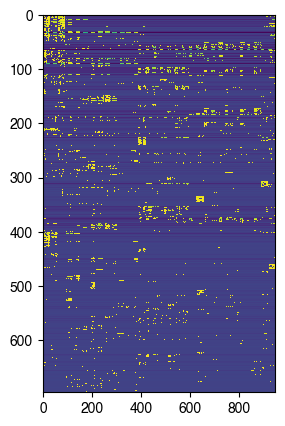

In [9]:
plt.figure(dpi=100, figsize=(3, 5))
plt.imshow(rank_data, aspect='auto')

## Calculate correlation

In [10]:
corr_data = corr(rank_data.values, rank_data.values)

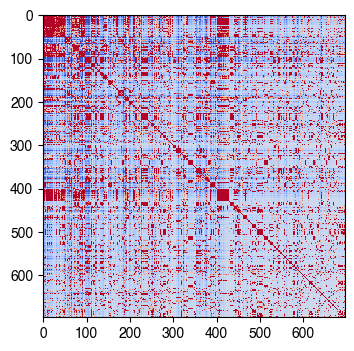

In [11]:
plt.figure(dpi=100)
plt.imshow(corr_data, vmin=-0.1, vmax=0.1, cmap='coolwarm')

## Clustering on correlation matrix

In [12]:
adata = anndata.AnnData(X=corr_data.copy(),
                        obs=pd.DataFrame([], index=rank_data.index),
                        var=pd.DataFrame([], index=rank_data.index))

In [13]:
sc.pp.scale(adata)

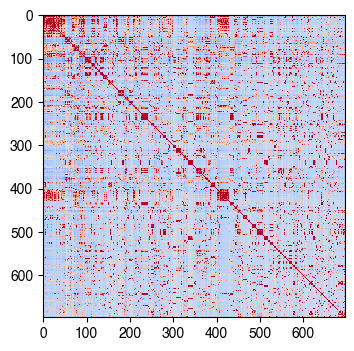

In [14]:
plt.figure(dpi=100)
plt.imshow(adata.X, vmin=-2, vmax=2, cmap='coolwarm')

In [15]:
sc.pp.pca(adata)

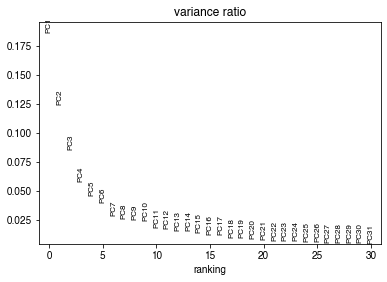

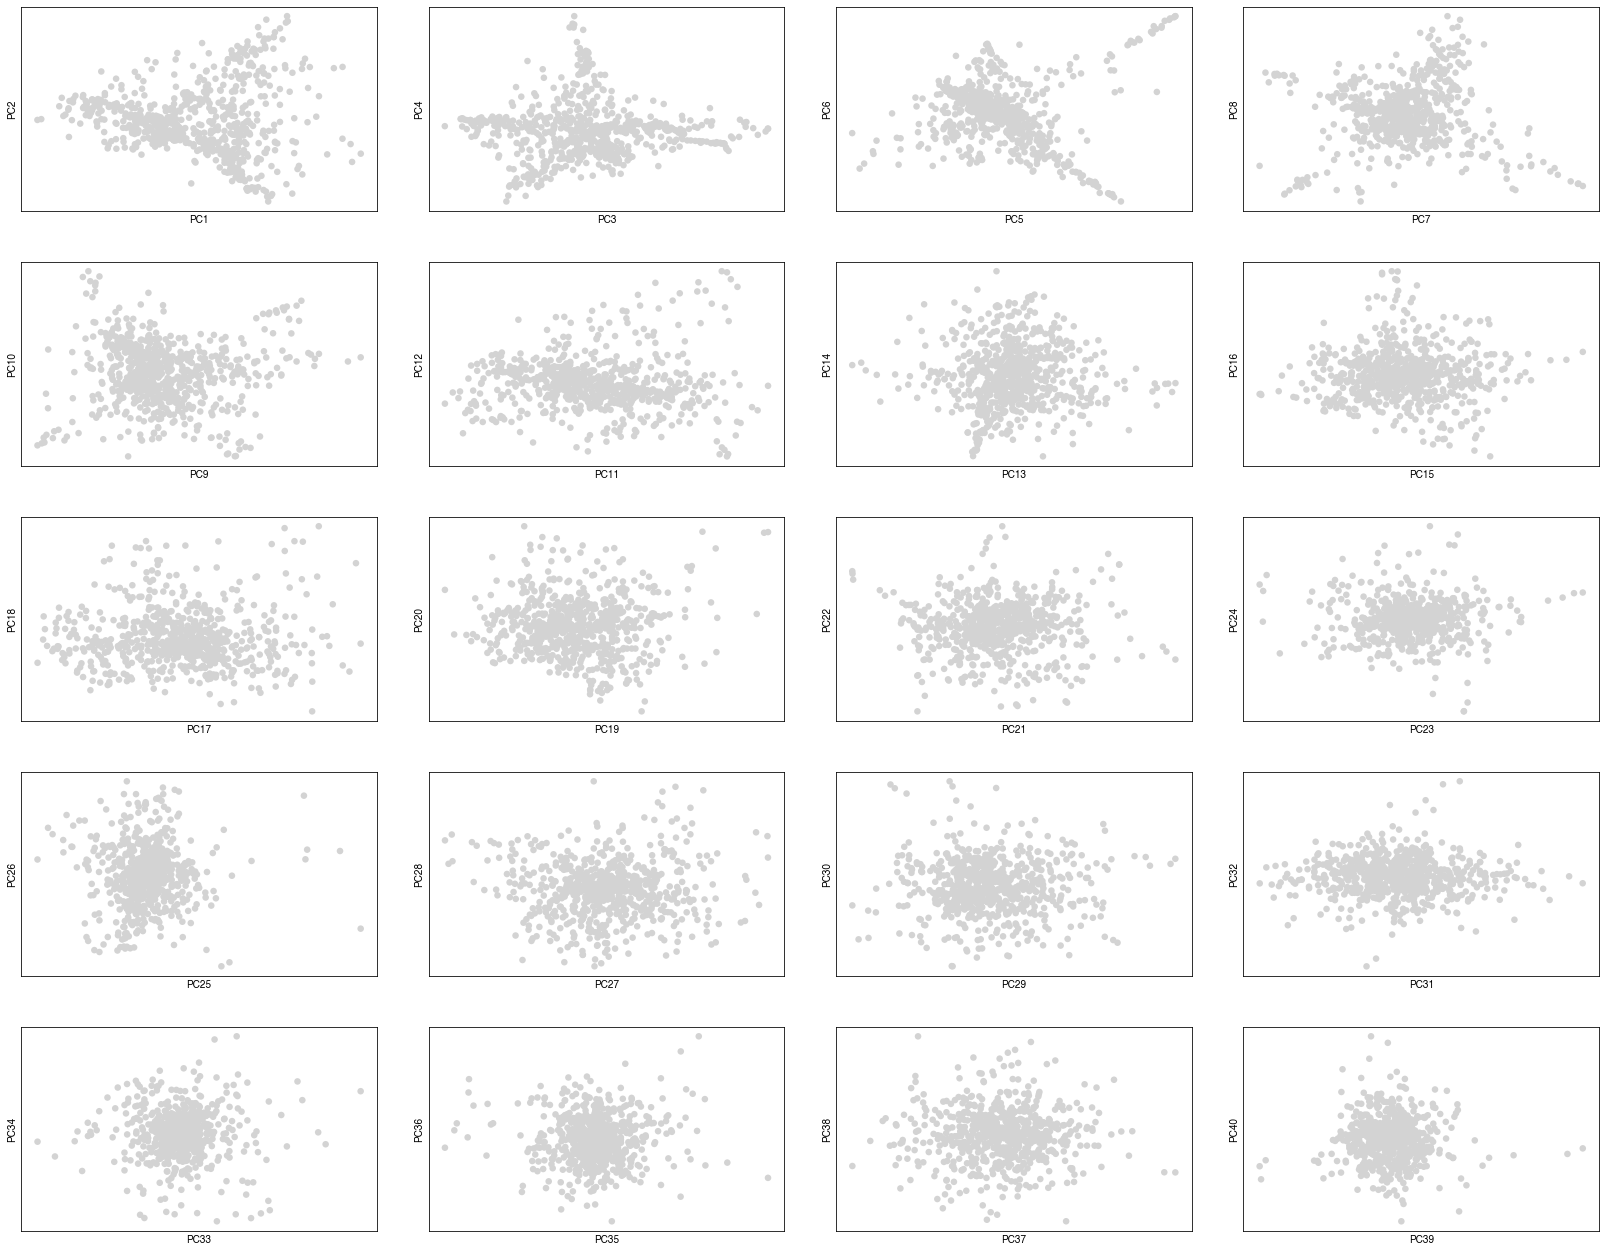

In [16]:
sc.pl.pca_variance_ratio(adata)
sc.pl.pca(adata,
          components=[
              '1,2', '3,4', '5,6', '7,8', '9,10', '11,12', '13,14', '15,16',
              '17,18', '19,20', '21,22', '23,24', '25,26', '27,28', '29,30',
              '31,32', '33, 34', '35, 36', '37, 38', '39, 40'
          ])

In [17]:
sc.pp.neighbors(adata, n_neighbors=k, n_pcs=n_pcs)

In [18]:
sc.tl.leiden(adata, resolution=resolution)

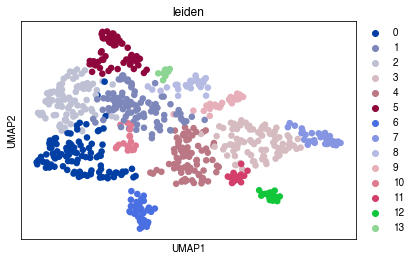

In [19]:
sc.tl.umap(adata)
sc.pl.umap(adata, color='leiden')

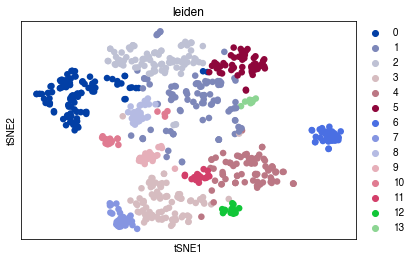

In [20]:
sc.tl.tsne(adata)
sc.pl.tsne(adata, color='leiden')

## Hierachical clustering of clusters to reorder

In [21]:
records = {}
for cluster, sub_df in adata.obs.groupby('leiden'):
    sub_adata = adata[:, sub_df.index].copy()
    sc.pp.scale(sub_adata)
    # some feature may become nan after scale for small cluster, remove them when calculate PC
    sub_adata = sub_adata[:, np.isnan(sub_adata.X).sum(axis=0) == 0].copy()
    sc.pp.pca(sub_adata, n_comps=1)
    pc1 = sub_adata.obsm['X_pca'][:, 0]
    records[cluster] = pd.Series(pc1, index=sub_adata.obs_names)
records = pd.DataFrame(records)

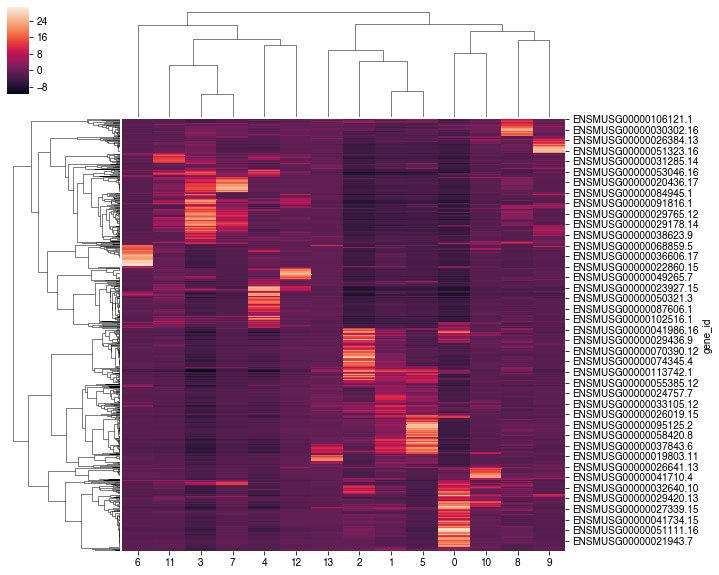

In [22]:
g = sns.clustermap(records, metric='correlation')

In [23]:
cluster_order = g.dendrogram_col.dendrogram['ivl']

In [24]:
# reorder cluster based on clstering of clusters
remap_cluster = {c:str(i) for i, c in enumerate(cluster_order)}
adata.obs['leiden'] = adata.obs['leiden'].astype(str).map(remap_cluster)

gene_order = adata.obs['leiden'].argsort().values

## Plot ordered matrix

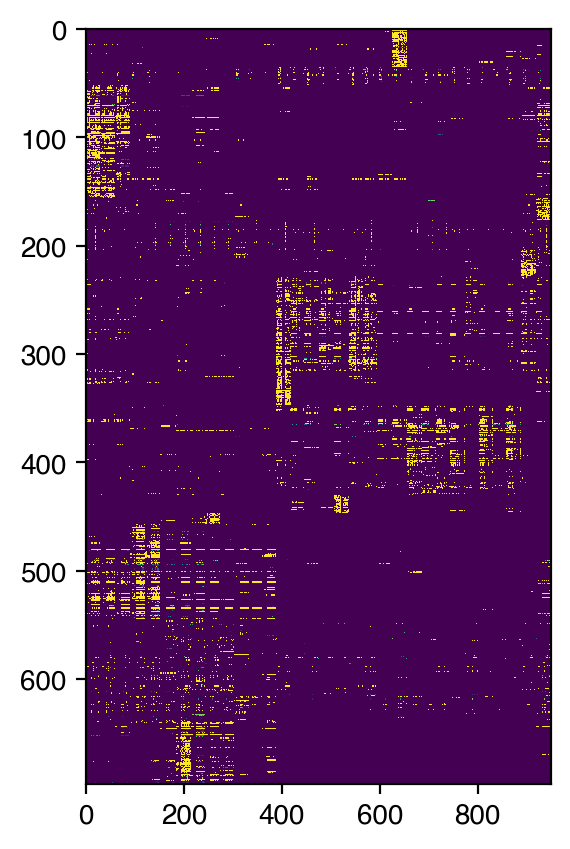

In [25]:
plt.figure(dpi=200, figsize=(3, 5))
plt.imshow(data.iloc[gene_order], vmin=0, vmax=10, aspect='auto')

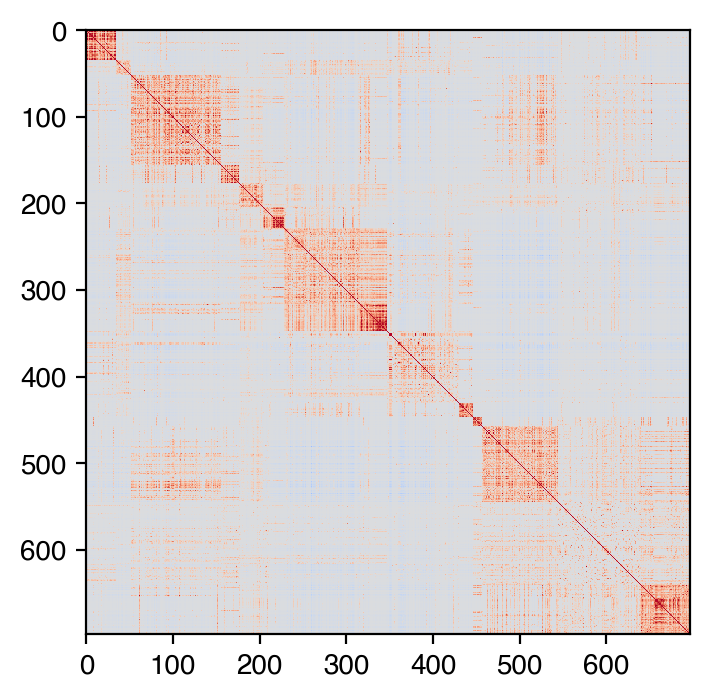

In [26]:
plt.figure(dpi=200)
plt.imshow(corr_data[:, gene_order][gene_order, :], vmin=-0.8, 
           vmax=0.8, cmap='coolwarm')

## TF Genes

In [27]:
gene_meta = pd.read_csv('/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz',
                        sep='\t', index_col='gene_id')
tf_genes = pd.read_csv('/home/hanliu/ref/TFGene/TFClass/TFClass.with_mouse_gene_id.csv', index_col=0)
tf_genes = set(','.join(tf_genes['EnsemblID'].dropna()).split(','))
gene_meta['TFGene'] = gene_meta.index.map(lambda i: i.split('.')[0] in tf_genes)

In [28]:
adata.obs['gene_name'] = gene_meta['gene_name']
adata.obs['TFGene'] = gene_meta['TFGene']

In [29]:
for cluster, sub_df in adata.obs[adata.obs['TFGene']].groupby('leiden'):
    if sub_df.shape[0] > 0:
        print(cluster)
        print(sub_df['gene_name'].tolist())

10
['Arntl', 'Zfp536', 'Tox2', 'Bcl11b', 'Zfp341', 'Pknox2']
11
['Arid5a']
12
['Zeb2', 'Ncoa1', 'Arnt2']
13
['Trps1', 'Nfil3']
2
['Lhx6', 'Fezf2', 'Mkx', 'Ahr', 'Klf3', 'Mef2c', 'Rc3h2']
3
['Tox3']
4
['Klf5', 'Bcl11a', 'Satb1', 'Zfp74', 'Npas1', 'Tshz3']
5
['Bcl6', 'Fosl2']
6
['Nr2e1', 'Zbtb18']
7
['Nfix', 'Prox1', 'Zbtb16', 'Npas3', 'Foxo6', 'Rxra']
8
['Usf1', 'Maf', 'Nr2f1', 'Sp9', 'Dnmt3a']
9
['Sall1', 'Srebf2', 'Sox8']


## Save

In [30]:
adata.write_h5ad('GeneClustering.h5ad')

... storing 'leiden' as categorical
... storing 'gene_name' as categorical
... storing 'TFGene' as categorical


## Check raw gene rates

In [31]:
import xarray as xr

In [32]:
gene_rates = xr.open_dataset(
    '/home/hanliu/project/mouse_rostral_brain/study/mCClustermCLevel/SubType.geneslop2k.mcds'
)
sub_type_gene_rate = gene_rates['gene_cluster_da_rate'].sel(mc_type='CHN').to_pandas()
sub_type_gene_rate = sub_type_gene_rate.T
use_genes = data.index[gene_order]

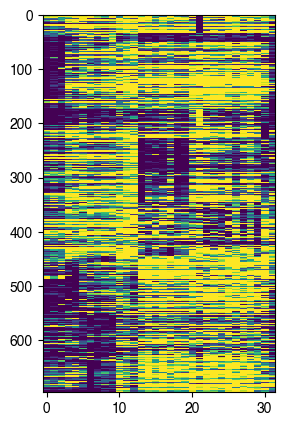

In [33]:
plt.figure(figsize=(3, 5), dpi=100)
plt.imshow(sub_type_gene_rate.loc[use_genes, use_clusters], 
           vmin=0.01, vmax=0.03, aspect='auto')

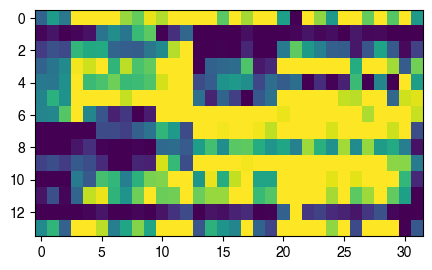

In [34]:
cluster_center = sub_type_gene_rate.loc[use_genes, use_clusters].groupby(adata.obs['leiden']).median()
plt.figure(figsize=(5, 3), dpi=100)
plt.imshow(cluster_center, 
           vmin=0.01, vmax=0.03, aspect='auto')